## Задание 1

#### Придумайте архитектуру свёрточной сети для решения задачи классификации на наборе данных MNIST. Обучите и протестируйте её. Постройте кривую обучения. Сохраните полученные параметры.

In [1]:
import copy
import torch
from torch import nn
import seaborn as sns
import matplotlib.pyplot as plt
from torchvision import transforms
from tensorboardX import SummaryWriter
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST, FashionMNIST

NUM_EPOCHS = 10
BATCH_SIZE = 64

In [2]:
class LeNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.feature_extractor = nn.Sequential(
            nn.LazyConv2d(out_channels=6, kernel_size=5),
            nn.Tanh(),
            nn.AvgPool2d(2),
            nn.LazyConv2d(out_channels=16, kernel_size=5),
            nn.Tanh(),
            nn.AvgPool2d(2),
            nn.LazyConv2d(out_channels=120, kernel_size=5)
        )

        self.classifier = nn.Sequential(
            nn.LazyLinear(out_features=84),
            nn.Tanh(),
            nn.LazyLinear(out_features=10)
        )

    def forward(self, x):
        out = self.feature_extractor(x)
        out = out.squeeze(-1).squeeze(-1)
        out = self.classifier(out)
        return out

In [3]:
criterion = nn.CrossEntropyLoss()


def train(model, train_loader, test_loader, unfreeze=0):
    train_losses, train_accuracies = [], []
    test_losses, test_accuracies = [], []
    i = 0
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    for epoch in range(NUM_EPOCHS):
        train_loss, train_accuracy = 0.0, 0.0

        if epoch == 3 and unfreeze:
            model5.feature_extractor[0].requires_grad_(True)
            model5.feature_extractor[3].requires_grad_(True)
            model5.feature_extractor[6].requires_grad_(True)

        model.train()

        for data, target in train_loader:
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            correct = (output.argmax(dim=1) == target).real.sum().item()
            train_loss += loss.item() * data.shape[0]
            train_accuracy += correct

            if i % (10000 / BATCH_SIZE) == 0:
                print('Train Step: {}\tLoss: {:.3f}\tAccuracy: {:.3f}'
                      .format(i, loss.item() * data.shape[0] / 100,
                              correct / BATCH_SIZE * 100))


            i += 1


        train_loss /= len(train_loader.dataset)
        train_accuracy /= len(train_loader.dataset)
        train_losses += [train_loss]
        train_accuracies += [train_accuracy]
        test_loss, test_accuracy = 0.0, 0.0
        model.eval()

        for data, target in test_loader:
            with torch.no_grad():
                output = model(data)
                loss = criterion(output, target)

            test_loss += loss.item() * data.shape[0]
            correct = (output.argmax(dim=1) == target).real.sum().item()
            test_accuracy += correct

        test_loss /= len(test_loader.dataset)
        test_accuracy /= len(test_loader.dataset)
        test_losses += [test_loss]
        test_accuracies += [test_accuracy]
        print('Test Epoch: {}\tLoss: {:.3f}\tAccuracy: {:.3f}'
              .format(epoch, test_loss, test_accuracy * 100))

    plot_losses(train_losses, test_losses, train_accuracies, test_accuracies)
    return train_losses, test_losses, train_accuracies, test_accuracies

In [4]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Resize((32, 32))])

mnist_train_loader = DataLoader(MNIST('MNIST', transform=transform, train=True, download=True),
                                batch_size=BATCH_SIZE, shuffle=True)

mnist_test_loader = DataLoader(MNIST('MNIST', transform=transform, train=False, download=True),
                               batch_size=BATCH_SIZE, shuffle=False)

fashionmnist_train_loader = DataLoader(FashionMNIST('FashionMNIST', transform=transform, train=True, download=True),
                                       batch_size=BATCH_SIZE, shuffle=True)

fashionmnist_test_loader = DataLoader(FashionMNIST('FashionMNIST', transform=transform, train=False, download=True),
                                      batch_size=BATCH_SIZE, shuffle=False)

In [5]:
sns.set_style('whitegrid')
plt.rcParams.update({'font.size': 15})


def plot_losses(train_losses, test_losses, train_accuracies, test_accuracies):
    fig, axs = plt.subplots(1, 2, figsize=(13, 4))
    axs[0].plot(range(1, len(train_losses) + 1), train_losses, label='train')
    axs[0].plot(range(1, len(test_losses) + 1), test_losses, label='test')
    axs[0].set_ylabel('loss')

    axs[1].plot(range(1, len(train_accuracies) + 1), train_accuracies, label='train')
    axs[1].plot(range(1, len(test_accuracies) + 1), test_accuracies, label='test')
    axs[1].set_ylabel('accuracy')

    for ax in axs:
        ax.set_xlabel('epoch')
        ax.legend()

    plt.show()

batch size torch.Size([64, 1, 32, 32])
img size torch.Size([1, 32, 32])


C:\Users\asus\PycharmProjects\ML\venv\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


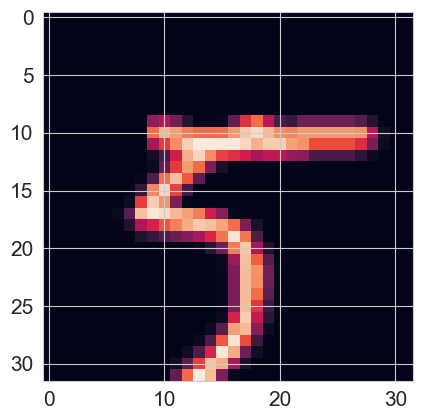

In [6]:
batch = 0

for batch in mnist_train_loader:
    break

print('batch size', batch[0].size())
print('img size', batch[0][1].size())
plt.imshow(batch[0][1][0])

C:\Users\asus\PycharmProjects\ML\venv\lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Train Step: 0	Loss: 1.474	Accuracy: 6.250
Train Step: 625	Loss: 0.258	Accuracy: 90.625
Test Epoch: 0	Loss: 0.388	Accuracy: 89.730
Train Step: 1250	Loss: 0.310	Accuracy: 85.938
Train Step: 1875	Loss: 0.065	Accuracy: 45.312
Test Epoch: 1	Loss: 0.283	Accuracy: 92.010
Train Step: 2500	Loss: 0.106	Accuracy: 98.438
Test Epoch: 2	Loss: 0.226	Accuracy: 93.390
Train Step: 3125	Loss: 0.145	Accuracy: 93.750
Train Step: 3750	Loss: 0.101	Accuracy: 98.438
Test Epoch: 3	Loss: 0.182	Accuracy: 94.670
Train Step: 4375	Loss: 0.178	Accuracy: 85.938
Test Epoch: 4	Loss: 0.151	Accuracy: 95.610
Train Step: 5000	Loss: 0.082	Accuracy: 93.750
Train Step: 5625	Loss: 0.149	Accuracy: 95.312
Test Epoch: 5	Loss: 0.129	Accuracy: 96.230
Train Step: 6250	Loss: 0.131	Accuracy: 96.875
Test Epoch: 6	Loss: 0.114	Accuracy: 96.650
Train Step: 6875	Loss: 0.084	Accuracy: 92.188
Train Step: 7500	Loss: 0.086	Accuracy: 98.438
Test Epoch: 7	Loss: 0.100	Accuracy: 97.060
Train Step: 8125	Loss: 0.020	Accuracy: 98.438
Test Epoch: 8	Los

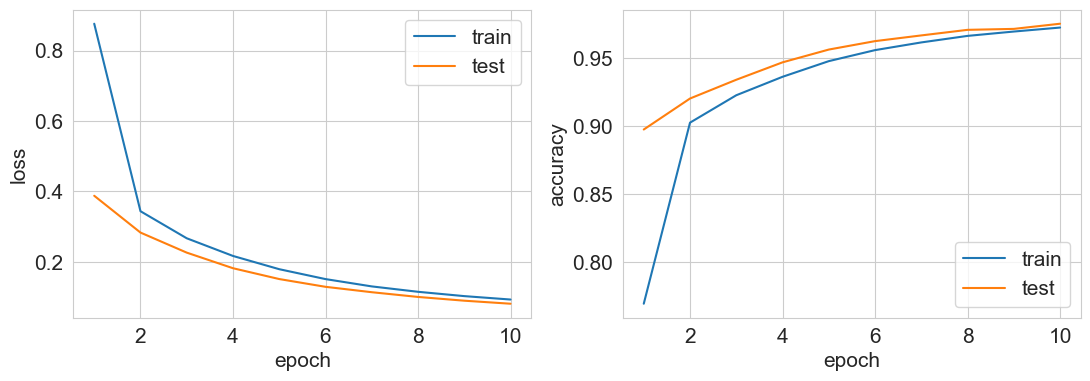

In [7]:
model1 = LeNet()
train_lossesMNIST, test_lossesMNIST, train_accuraciesMNIST, test_accuraciesMNIST = train(model1,
                                                                                         mnist_train_loader,
                                                                                         mnist_test_loader)

In [ ]:
writer = SummaryWriter()

for step in range(len(test_lossesMNIST)):
    writer.add_scalar('test/loss1', test_lossesMNIST[step], step)
    writer.add_scalar('test/accuracy1', test_accuraciesMNIST[step], step)
    writer.add_scalar('test/loss', test_lossesMNIST[step], step)
    writer.add_scalar('test/accuracy', test_accuraciesMNIST[step], step)

In [1]:
%reload_ext tensorboard
%tensorboard --logdir runs

Launching TensorBoard...

In [9]:
from torchsummaryX import summary

print(summary(model1, torch.ones(BATCH_SIZE, 1, 32, 32)))

                                    Kernel Shape      Output Shape   Params  \
Layer                                                                         
0_feature_extractor.Conv2d_0        [1, 6, 5, 5]   [64, 6, 28, 28]    156.0   
1_feature_extractor.Tanh_1                     -   [64, 6, 28, 28]        -   
2_feature_extractor.AvgPool2d_2                -   [64, 6, 14, 14]        -   
3_feature_extractor.Conv2d_3       [6, 16, 5, 5]  [64, 16, 10, 10]   2.416k   
4_feature_extractor.Tanh_4                     -  [64, 16, 10, 10]        -   
5_feature_extractor.AvgPool2d_5                -    [64, 16, 5, 5]        -   
6_feature_extractor.Conv2d_6     [16, 120, 5, 5]   [64, 120, 1, 1]   48.12k   
7_classifier.Linear_0                  [120, 84]          [64, 84]  10.164k   
8_classifier.Tanh_1                            -          [64, 84]        -   
9_classifier.Linear_2                   [84, 10]          [64, 10]    850.0   

                                Mult-Adds  
Layer  

C:\Users\asus\PycharmProjects\ML\venv\lib\site-packages\torchsummaryX\torchsummaryX.py:101: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_sum = df.sum()


## Задание 2

### Обучите и протестируйте ту же самую архитектуру на наборе данных Fashion-MNIST. Постройте кривую обучения.

batch size torch.Size([64, 1, 32, 32])
img size torch.Size([1, 32, 32])


C:\Users\asus\PycharmProjects\ML\venv\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


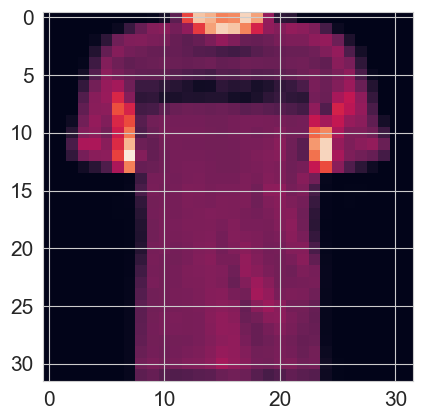

In [10]:
for batch in fashionmnist_train_loader:
    break

print('batch size', batch[0].size())
print('img size', batch[0][3].size())
plt.imshow(batch[0][3][0])

C:\Users\asus\PycharmProjects\ML\venv\lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Train Step: 0	Loss: 1.473	Accuracy: 3.125
Train Step: 625	Loss: 0.529	Accuracy: 75.000
Test Epoch: 0	Loss: 0.760	Accuracy: 72.390
Train Step: 1250	Loss: 0.592	Accuracy: 64.062
Train Step: 1875	Loss: 0.142	Accuracy: 45.312
Test Epoch: 1	Loss: 0.645	Accuracy: 75.470
Train Step: 2500	Loss: 0.288	Accuracy: 81.250
Test Epoch: 2	Loss: 0.588	Accuracy: 78.140
Train Step: 3125	Loss: 0.524	Accuracy: 71.875
Train Step: 3750	Loss: 0.241	Accuracy: 85.938
Test Epoch: 3	Loss: 0.554	Accuracy: 79.640
Train Step: 4375	Loss: 0.314	Accuracy: 81.250
Test Epoch: 4	Loss: 0.537	Accuracy: 80.440
Train Step: 5000	Loss: 0.345	Accuracy: 87.500
Train Step: 5625	Loss: 0.330	Accuracy: 84.375
Test Epoch: 5	Loss: 0.516	Accuracy: 81.360
Train Step: 6250	Loss: 0.375	Accuracy: 81.250
Test Epoch: 6	Loss: 0.505	Accuracy: 81.740
Train Step: 6875	Loss: 0.334	Accuracy: 82.812
Train Step: 7500	Loss: 0.287	Accuracy: 84.375
Test Epoch: 7	Loss: 0.488	Accuracy: 82.400
Train Step: 8125	Loss: 0.304	Accuracy: 84.375
Test Epoch: 8	Los

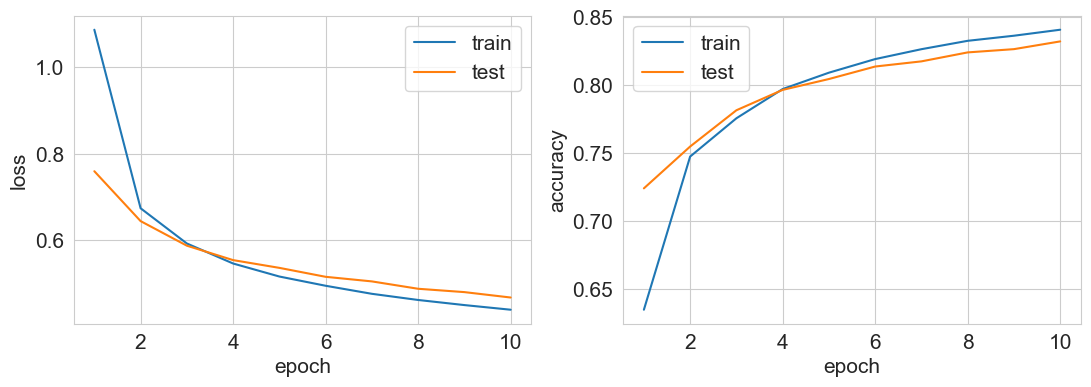

In [11]:
model2 = LeNet()
train_lossesFMNIST, test_lossesFMNIST, train_accuraciesFMNIST, test_accuraciesFMNIST = train(model2,
                                                                                             fashionmnist_train_loader,
                                                                                             fashionmnist_test_loader)

In [ ]:
writer = SummaryWriter()

for step in range(len(test_lossesFMNIST)):
    writer.add_scalar('test/loss2', test_lossesFMNIST[step], step)
    writer.add_scalar('test/accuracy2', test_accuraciesFMNIST[step], step)
    writer.add_scalar('test/loss', test_lossesFMNIST[step], step)
    writer.add_scalar('test/accuracy', test_accuraciesFMNIST[step], step)

In [8]:
#%load_ext tensorboard
%tensorboard --logdir runs

Launching TensorBoard...

## Задание 3

### Повторите предыдущий эксперимент, но начните обучения не со случайных параметров, а с сохранённых в первом пункте.

Train Step: 0	Loss: 4.624	Accuracy: 9.375
Train Step: 625	Loss: 0.474	Accuracy: 68.750
Test Epoch: 0	Loss: 0.788	Accuracy: 71.840
Train Step: 1250	Loss: 0.502	Accuracy: 71.875
Train Step: 1875	Loss: 0.193	Accuracy: 34.375
Test Epoch: 1	Loss: 0.642	Accuracy: 76.030
Train Step: 2500	Loss: 0.339	Accuracy: 81.250
Test Epoch: 2	Loss: 0.572	Accuracy: 79.060
Train Step: 3125	Loss: 0.426	Accuracy: 76.562
Train Step: 3750	Loss: 0.357	Accuracy: 76.562
Test Epoch: 3	Loss: 0.532	Accuracy: 80.650
Train Step: 4375	Loss: 0.162	Accuracy: 93.750
Test Epoch: 4	Loss: 0.506	Accuracy: 82.100
Train Step: 5000	Loss: 0.315	Accuracy: 79.688
Train Step: 5625	Loss: 0.340	Accuracy: 78.125
Test Epoch: 5	Loss: 0.491	Accuracy: 81.910
Train Step: 6250	Loss: 0.299	Accuracy: 84.375
Test Epoch: 6	Loss: 0.468	Accuracy: 83.630
Train Step: 6875	Loss: 0.375	Accuracy: 76.562
Train Step: 7500	Loss: 0.250	Accuracy: 84.375
Test Epoch: 7	Loss: 0.467	Accuracy: 82.990
Train Step: 8125	Loss: 0.289	Accuracy: 73.438
Test Epoch: 8	Los

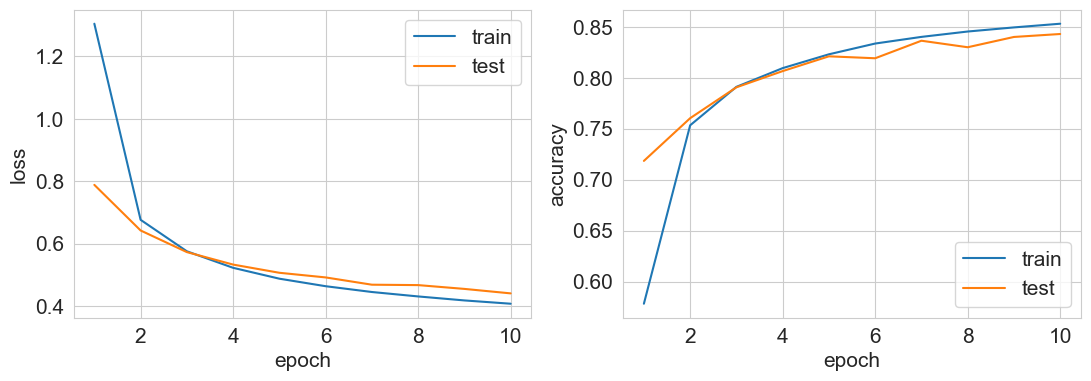

In [13]:
model3 = copy.deepcopy(model1)
train_lossesFMNIST2, test_lossesFMNIST2, train_accuraciesFMNIST2, test_accuraciesFMNIST2 = train(model3,
                                                                                                 fashionmnist_train_loader,
                                                                                                 fashionmnist_test_loader)

In [ ]:
writer = SummaryWriter()

for step in range(len(test_lossesFMNIST2)):
    writer.add_scalar('test/loss3', test_lossesFMNIST2[step], step)
    writer.add_scalar('test/accuracy3', test_accuraciesFMNIST2[step], step)
    writer.add_scalar('test/loss', test_lossesFMNIST2[step], step)
    writer.add_scalar('test/accuracy', test_accuraciesFMNIST2[step], step)

In [ ]:
#%load_ext tensorboard
%tensorboard --logdir runs

## Задание 4

### Повторите предыдущий эксперимент, но заморозьте параметры на свёрточных слоях.

Train Step: 0	Loss: 4.630	Accuracy: 6.250
Train Step: 625	Loss: 0.839	Accuracy: 59.375
Test Epoch: 0	Loss: 1.157	Accuracy: 58.330
Train Step: 1250	Loss: 0.707	Accuracy: 62.500
Train Step: 1875	Loss: 0.274	Accuracy: 34.375
Test Epoch: 1	Loss: 0.945	Accuracy: 64.750
Train Step: 2500	Loss: 0.619	Accuracy: 62.500
Test Epoch: 2	Loss: 0.860	Accuracy: 67.810
Train Step: 3125	Loss: 0.478	Accuracy: 71.875
Train Step: 3750	Loss: 0.567	Accuracy: 64.062
Test Epoch: 3	Loss: 0.809	Accuracy: 69.370
Train Step: 4375	Loss: 0.489	Accuracy: 75.000
Test Epoch: 4	Loss: 0.771	Accuracy: 70.920
Train Step: 5000	Loss: 0.562	Accuracy: 65.625
Train Step: 5625	Loss: 0.406	Accuracy: 78.125
Test Epoch: 5	Loss: 0.742	Accuracy: 72.360
Train Step: 6250	Loss: 0.375	Accuracy: 76.562
Test Epoch: 6	Loss: 0.717	Accuracy: 73.560
Train Step: 6875	Loss: 0.483	Accuracy: 73.438
Train Step: 7500	Loss: 0.458	Accuracy: 78.125
Test Epoch: 7	Loss: 0.699	Accuracy: 74.290
Train Step: 8125	Loss: 0.451	Accuracy: 68.750
Test Epoch: 8	Los

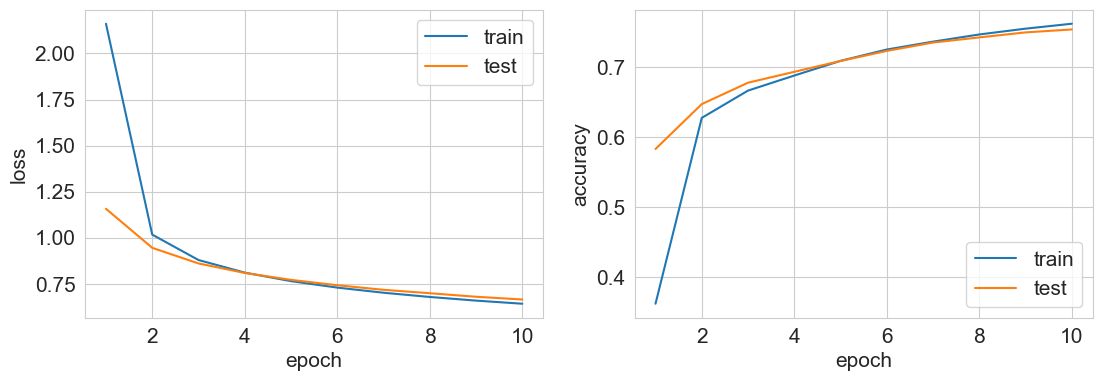

In [15]:
model4 = copy.deepcopy(model1)
model4.feature_extractor[0].requires_grad_(False)
model4.feature_extractor[3].requires_grad_(False)
model4.feature_extractor[6].requires_grad_(False)
train_lossesFMNIST3, test_lossesFMNIST3, train_accuraciesFMNIST3, test_accuraciesFMNIST3 = train(model4,
                                                                                                 fashionmnist_train_loader,
                                                                                                 fashionmnist_test_loader)

In [ ]:
writer = SummaryWriter()

for step in range(len(test_lossesFMNIST3)):
    writer.add_scalar('test/loss4', test_lossesFMNIST3[step], step)
    writer.add_scalar('test/accuracy4', test_accuraciesFMNIST3[step], step)
    writer.add_scalar('test/loss', test_lossesFMNIST3[step], step)
    writer.add_scalar('test/accuracy', test_accuraciesFMNIST3[step], step)

In [ ]:
#%load_ext tensorboard
%tensorboard --logdir runs

## Задание 5

### Повторите предыдущий эксперимент, но после нескольких эпох разморозьте и дообучите параметры.

Train Step: 0	Loss: 4.278	Accuracy: 6.250
Train Step: 625	Loss: 0.948	Accuracy: 45.312
Test Epoch: 0	Loss: 1.156	Accuracy: 58.920
Train Step: 1250	Loss: 0.697	Accuracy: 57.812
Train Step: 1875	Loss: 0.301	Accuracy: 31.250
Test Epoch: 1	Loss: 0.947	Accuracy: 65.460
Train Step: 2500	Loss: 0.658	Accuracy: 60.938
Test Epoch: 2	Loss: 0.864	Accuracy: 67.180
Train Step: 3125	Loss: 0.537	Accuracy: 70.312
Train Step: 3750	Loss: 0.372	Accuracy: 76.562
Test Epoch: 3	Loss: 0.653	Accuracy: 75.650
Train Step: 4375	Loss: 0.341	Accuracy: 79.688
Test Epoch: 4	Loss: 0.567	Accuracy: 79.240
Train Step: 5000	Loss: 0.215	Accuracy: 90.625
Train Step: 5625	Loss: 0.428	Accuracy: 78.125
Test Epoch: 5	Loss: 0.535	Accuracy: 80.740
Train Step: 6250	Loss: 0.279	Accuracy: 82.812
Test Epoch: 6	Loss: 0.501	Accuracy: 81.420
Train Step: 6875	Loss: 0.412	Accuracy: 73.438
Train Step: 7500	Loss: 0.304	Accuracy: 82.812
Test Epoch: 7	Loss: 0.482	Accuracy: 82.400
Train Step: 8125	Loss: 0.257	Accuracy: 85.938
Test Epoch: 8	Los

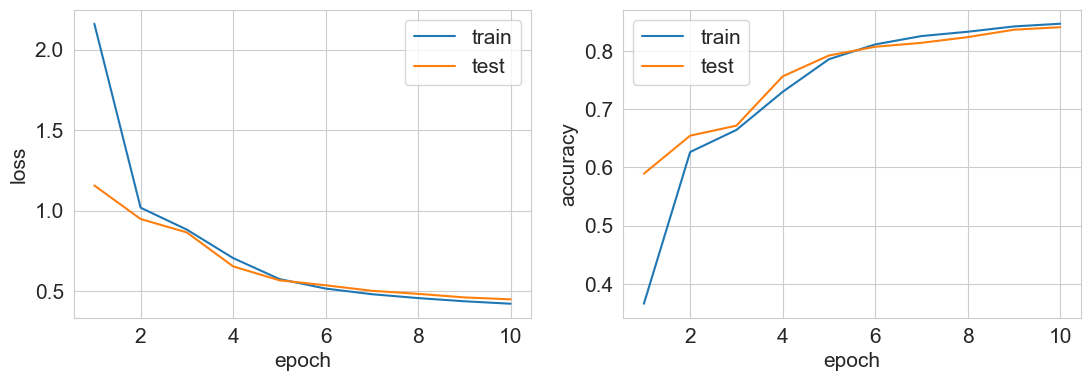

In [17]:
model5 = copy.deepcopy(model1)
model5.feature_extractor[0].requires_grad_(False)
model5.feature_extractor[3].requires_grad_(False)
model5.feature_extractor[6].requires_grad_(False)
train_lossesFMNIST4, test_lossesFMNIST4, train_accuraciesFMNIST4, test_accuraciesFMNIST4 = train(model5,
                                                                                                 fashionmnist_train_loader,
                                                                                                 fashionmnist_test_loader,
                                                                                                 1)

In [ ]:
writer = SummaryWriter()

for step in range(len(test_lossesFMNIST4)):
    writer.add_scalar('test/loss5', test_lossesFMNIST4[step], step)
    writer.add_scalar('test/accuracy5', test_accuraciesFMNIST4[step], step)
    writer.add_scalar('test/loss', test_lossesFMNIST4[step], step)
    writer.add_scalar('test/accuracy', test_accuraciesFMNIST4[step], step)

In [ ]:
#%load_ext tensorboard
%tensorboard --logdir runs